<img>
<html>
  <head>
  </head>

  <body>
    <img src="image/molecule image.jpg">
  </body>
</html>

# Overview

A common challenge in experimental chemistry is inferring causality from small datasets. Chemists often synthesize around 100 molecules, measure a key property, and then attempt to identify which molecular features influence that property. This process typically relies on expert intuition to select meaningful features, followed by multivariate linear regression for feature importance analysis.

Our recent work at the **NSF's Molecule Maker Lab Institute**, published in *Nature*, demonstrated that a **purely data-driven machine learning approach** can:
1. Identify important molecular features previously overlooked by experts.
2. Generate a regression model for photostability that performs well on newly synthesized molecules.

This approach has shown significant promise in discovering and enhancing **molecular photostability** (e.g., for organic solar cells), and we aim to build upon this success to enable broader data-driven discoveries in chemistry.

---

# Challenge

The goal of this competition is to:
> **Identify the best algorithm to select the most informative molecular features and accurately regress the experimental property (T80) for new molecules.**

You are provided with:
- A small dataset (~100 molecules).
- A large number of calculated (but mostly irrelevant) features.
- An experimental property: **photostability lifetime (T80)**.

---

# Dataset & Resources

- **Training and test datasets** include ~150 molecular features.
- **SMILES strings** (textual molecular representations) are included.
- Features can be extended using **RDKit** or other cheminformatics tools.
- Example RDKit script is available in the `SmilesStrings Dataset`.

You may also utilize:
- **Pre-trained models** (e.g., FARM or other SMILES-based models).
- Traditional models without any pre-trained feature extraction.

---

# Model Development Insights

In our previous research, we evaluated **Support Vector Regression (SVR)** models trained on approximately **2.5 million combinations** of molecular features.

Key findings:
- **Top 3 predictive features** identified:
  - `TDOS4.0`
  - `NumHeteroatoms` (number of non-carbon, non-hydrogen atoms)
  - `Mass`
- **TDOS4.0** (and its correlated counterpart `TDOS3.9`) was physically validated.
- **NumHeteroatoms** and **Mass** were not physically analyzed yet — open for discovery.

---

# Evaluation

To encourage innovation:
- We have synthesized **9 new molecules** and measured their **T80 values**.
- These will serve as the test set to evaluate submitted models.

Prizes will be awarded for:
- Best model **using pre-trained SMILES models**.
- Best model **not using pre-trained models** (classical feature-based approach).

---

Good luck, and happy modeling!


---
- About the Author : Sajjad Ali Shah
- Contact: [Linkedin](www.linkedin.com/in/sajjad-ali-shah-120341305)
- Dataset: [Link](https://www.kaggle.com/competitions/molecular-machine-learning/overview)
- Date : 02/10/2024
---

In [81]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Lasso
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem
import warnings
warnings.filterwarnings("ignore")

# Set random seed for reproducibility
np.random.seed(42)

In [82]:
# load the data 
df_train=pd.read_csv("../molecular-machine-learning/data/train.csv")
df_test=pd.read_csv("../molecular-machine-learning/data/test.csv")
submission=pd.read_csv("../molecular-machine-learning/data/sample_submission.csv")

In [83]:
# let us see the data
df_train.head()

,Batch_ID,T80,Smiles,Mass,HAcceptors,HDonors,LogP,Asphericity,Rg,TPSA,RingCount,NumRotatableBonds,NumHeteroatoms,HOMOm1(eV),HOMO(eV),LUMO(eV),LUMOp1(eV),PrimeState,PrimeExcite(eV),PrimeExcite(osc),DipoleMoment(Debye),SurfaceCharge,ChargeCorrection,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T11,T12,T13,T14,T15,T16,T17,T18,T19,T20,S1,S2,S3,S4,S5,S6,S7,S8,S9,S10,S11,S12,S13,S14,S15,S16,S17,S18,S19,S20,O1,O2,O3,O4,O5,O6,O7,O8,O9,O10,O11,O12,O13,O14,O15,O16,O17,O18,O19,O20,TDOS1.5,TDOS1.6,TDOS1.7,TDOS1.8,TDOS1.9,TDOS2.0,TDOS2.1,TDOS2.2,TDOS2.3,TDOS2.4,TDOS2.5,TDOS2.6,TDOS2.7,TDOS2.8,TDOS2.9,TDOS3.0,TDOS3.1,TDOS3.2,TDOS3.3,TDOS3.4,TDOS3.5,TDOS3.6,TDOS3.7,TDOS3.8,TDOS3.9,TDOS4.0,TDOS4.1,TDOS4.2,TDOS4.3,TDOS4.4,TDOS4.5,TDOS4.6,TDOS4.7,SDOS2.5,SDOS2.6,SDOS2.7,SDOS2.8,SDOS2.9,SDOS3.0,SDOS3.1,SDOS3.2,SDOS3.3,SDOS3.4,SDOS3.5,SDOS3.6,SDOS3.7,SDOS3.8,SDOS3.9,SDOS4.0,SDOS4.1,SDOS4.2,SDOS4.3,SDOS4.4,SDOS4.5,SDOS4.6,SDOS4.7,SDOS4.8,SDOS4.9,SDOS5.0,SDOS5.1,SDOS5.2,SDOS5.3,SDOS5.4
0,Train-01,103.86,CCCCCCCCCCCCc1ccsc1-c1ccc(-c2cccs2)cc1,410.692,2,0,9.6070,0.301361,5.187321,0.00,3,13,2,-8.8374,-7.8893,0.3472,1.4773,1,4.604816,0.987886,0.57258,-0.038114,0.00245,3.135243,3.673961,4.292212,4.432521,4.475070,4.486092,4.755836,4.813945,5.640073,5.913449,6.030660,6.114731,6.245629,6.267871,6.451262,6.490043,6.554413,6.597794,6.778545,6.957696,4.604816,5.008457,5.535707,5.777369,5.806281,6.180701,6.321331,6.460635,6.465954,6.654304,6.656871,6.819904,6.920167,6.951335,7.059793,7.263257,7.330665,7.407061,7.430419,7.571409,0.987886,0.000843,0.015068,0.017847,0.104293,0.056222,0.072319,0.059375,0.051553,0.021097,0.022424,0.028070,0.003625,0.038192,0.010176,0.602064,0.016987,0.065429,0.015649,0.118870,6.070000e-15,3.200000e-13,1.310000e-11,4.180000e-10,1.040000e-08,2.010000e-07,3.030000e-06,3.560000e-05,3.255820e-04,0.002319,0.012859,0.055546,0.186862,0.489651,0.999874,1.593854,1.996452,2.013180,1.768059,1.611227,1.745397,2.002522,2.044195,1.765658,1.463189,1.631723,2.629855,4.422731,6.485324,8.017557,8.478704,7.950547,6.865207,1.750000e-24,2.990000e-22,3.960000e-20,4.090000e-18,3.290000e-16,2.060000e-14,1.000000e-12,3.810000e-11,1.130000e-09,2.600000e-08,4.660000e-07,6.510000e-06,7.080000e-05,6.001750e-04,3.961032e-03,2.035942e-02,0.081498,0.254073,0.616874,1.166442,1.717761,1.970186,1.760071,1.224983,0.664733,0.282353,0.096763,0.034589,0.030793,0.057340
1,Train-02,101.13,CCCCCCCCCCCCc1ccsc1-c1cccs1,334.594,2,0,7.9400,0.367472,4.141425,0.00,2,12,2,-9.0870,-8.2034,0.8586,1.8912,1,5.074787,0.386292,1.68691,-0.039476,0.00243,3.385683,3.898514,4.438670,4.616185,5.703688,5.850009,6.111718,6.188610,6.315764,6.339197,6.467256,6.607167,6.695862,6.890114,7.120618,7.124449,7.201143,7.294277,7.600110,7.752693,5.074787,5.814575,5.920305,6.014307,6.291501,6.587479,6.659053,6.802349,6.891912,7.142401,7.317014,7.322656,7.652938,7.782386,7.858026,8.006802,8.008972,8.124261,8.245476,8.323199,0.386292,0.075833,0.018200,0.090356,0.013351,0.007066,0.034101,0.001254,0.032699,0.042854,0.009285,0.013903,0.003854,0.003978,0.175448,0.046715,0.256225,0.023161,0.121842,0.007268,9.920000e-20,9.760000e-18,7.480000e-16,4.470000e-14,2.080000e-12,7.520000e-11,2.120000e-09,4.660000e-08,7.960000e-07,0.000011,0.000110,0.000889,0.005591,0.027398,0.104557,0.310793,0.719839,1.300789,1.842464,2.078892,1.968111,1.778528,1.801242,2.012835,2.124073,1.968890,1.751188,1.848447,2.406233,3.155962,3.609764,3.433183,2.677125,7.890000e-37,4.350000e-34,1.870000e-31,6.240000e-29,1.620000e-26,3.290000e-24,5.200000e-22,6.400000e-20,6.130000e-18,4.570000e-16,2.650000e-14,1.200000e-12,4.230000e-11,1.160000e-09,2.480000e-08,4.130000e-07,0.000005,0.000054,0.000425,0.002600,0.012396,0.046031,0.133124,0.299840,0.525958,0.718549,0.764711,0.634854,0.414866,0.225909
2,Train-03,78.30,CN1CCN(S(=O)(=O)c2ccc(-c3ccc(-c4cccs4)cc3)cc2)CC1,398.553,4,0,4.0182,0.799589,5.368024,40.62,4,4,6,-8.2055,-8.0072,0.0730,1.2317,1,4.591711,1.277359,8.93223,-0.032458,-0.00467,3.175326,3.780857,4.331316,4.494994,4.526621,4.553525,4.610283,4.707483,4.7

In [84]:
# Display all columns in the DataFrame
pd.set_option('display.max_columns', None)

# Now display the DataFrame
df_train.head()

,Batch_ID,T80,Smiles,Mass,HAcceptors,HDonors,LogP,Asphericity,Rg,TPSA,RingCount,NumRotatableBonds,NumHeteroatoms,HOMOm1(eV),HOMO(eV),LUMO(eV),LUMOp1(eV),PrimeState,PrimeExcite(eV),PrimeExcite(osc),DipoleMoment(Debye),SurfaceCharge,ChargeCorrection,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T11,T12,T13,T14,T15,T16,T17,T18,T19,T20,S1,S2,S3,S4,S5,S6,S7,S8,S9,S10,S11,S12,S13,S14,S15,S16,S17,S18,S19,S20,O1,O2,O3,O4,O5,O6,O7,O8,O9,O10,O11,O12,O13,O14,O15,O16,O17,O18,O19,O20,TDOS1.5,TDOS1.6,TDOS1.7,TDOS1.8,TDOS1.9,TDOS2.0,TDOS2.1,TDOS2.2,TDOS2.3,TDOS2.4,TDOS2.5,TDOS2.6,TDOS2.7,TDOS2.8,TDOS2.9,TDOS3.0,TDOS3.1,TDOS3.2,TDOS3.3,TDOS3.4,TDOS3.5,TDOS3.6,TDOS3.7,TDOS3.8,TDOS3.9,TDOS4.0,TDOS4.1,TDOS4.2,TDOS4.3,TDOS4.4,TDOS4.5,TDOS4.6,TDOS4.7,SDOS2.5,SDOS2.6,SDOS2.7,SDOS2.8,SDOS2.9,SDOS3.0,SDOS3.1,SDOS3.2,SDOS3.3,SDOS3.4,SDOS3.5,SDOS3.6,SDOS3.7,SDOS3.8,SDOS3.9,SDOS4.0,SDOS4.1,SDOS4.2,SDOS4.3,SDOS4.4,SDOS4.5,SDOS4.6,SDOS4.7,SDOS4.8,SDOS4.9,SDOS5.0,SDOS5.1,SDOS5.2,SDOS5.3,SDOS5.4
0,Train-01,103.86,CCCCCCCCCCCCc1ccsc1-c1ccc(-c2cccs2)cc1,410.692,2,0,9.6070,0.301361,5.187321,0.00,3,13,2,-8.8374,-7.8893,0.3472,1.4773,1,4.604816,0.987886,0.57258,-0.038114,0.00245,3.135243,3.673961,4.292212,4.432521,4.475070,4.486092,4.755836,4.813945,5.640073,5.913449,6.030660,6.114731,6.245629,6.267871,6.451262,6.490043,6.554413,6.597794,6.778545,6.957696,4.604816,5.008457,5.535707,5.777369,5.806281,6.180701,6.321331,6.460635,6.465954,6.654304,6.656871,6.819904,6.920167,6.951335,7.059793,7.263257,7.330665,7.407061,7.430419,7.571409,0.987886,0.000843,0.015068,0.017847,0.104293,0.056222,0.072319,0.059375,0.051553,0.021097,0.022424,0.028070,0.003625,0.038192,0.010176,0.602064,0.016987,0.065429,0.015649,0.118870,6.070000e-15,3.200000e-13,1.310000e-11,4.180000e-10,1.040000e-08,2.010000e-07,3.030000e-06,3.560000e-05,3.255820e-04,0.002319,0.012859,0.055546,0.186862,0.489651,0.999874,1.593854,1.996452,2.013180,1.768059,1.611227,1.745397,2.002522,2.044195,1.765658,1.463189,1.631723,2.629855,4.422731,6.485324,8.017557,8.478704,7.950547,6.865207,1.750000e-24,2.990000e-22,3.960000e-20,4.090000e-18,3.290000e-16,2.060000e-14,1.000000e-12,3.810000e-11,1.130000e-09,2.600000e-08,4.660000e-07,6.510000e-06,7.080000e-05,6.001750e-04,3.961032e-03,2.035942e-02,0.081498,0.254073,0.616874,1.166442,1.717761,1.970186,1.760071,1.224983,0.664733,0.282353,0.096763,0.034589,0.030793,0.057340
1,Train-02,101.13,CCCCCCCCCCCCc1ccsc1-c1cccs1,334.594,2,0,7.9400,0.367472,4.141425,0.00,2,12,2,-9.0870,-8.2034,0.8586,1.8912,1,5.074787,0.386292,1.68691,-0.039476,0.00243,3.385683,3.898514,4.438670,4.616185,5.703688,5.850009,6.111718,6.188610,6.315764,6.339197,6.467256,6.607167,6.695862,6.890114,7.120618,7.124449,7.201143,7.294277,7.600110,7.752693,5.074787,5.814575,5.920305,6.014307,6.291501,6.587479,6.659053,6.802349,6.891912,7.142401,7.317014,7.322656,7.652938,7.782386,7.858026,8.006802,8.008972,8.124261,8.245476,8.323199,0.386292,0.075833,0.018200,0.090356,0.013351,0.007066,0.034101,0.001254,0.032699,0.042854,0.009285,0.013903,0.003854,0.003978,0.175448,0.046715,0.256225,0.023161,0.121842,0.007268,9.920000e-20,9.760000e-18,7.480000e-16,4.470000e-14,2.080000e-12,7.520000e-11,2.120000e-09,4.660000e-08,7.960000e-07,0.000011,0.000110,0.000889,0.005591,0.027398,0.104557,0.310793,0.719839,1.300789,1.842464,2.078892,1.968111,1.778528,1.801242,2.012835,2.124073,1.968890,1.751188,1.848447,2.406233,3.155962,3.609764,3.433183,2.677125,7.890000e-37,4.350000e-34,1.870000e-31,6.240000e-29,1.620000e-26,3.290000e-24,5.200000e-22,6.400000e-20,6.130000e-18,4.570000e-16,2.650000e-14,1.200000e-12,4.230000e-11,1.160000e-09,2.480000e-08,4.130000e-07,0.000005,0.000054,0.000425,0.002600,0.012396,0.046031,0.133124,0.299840,0.525958,0.718549,0.764711,0.634854,0.414866,0.225909
2,Train-03,78.30,CN1CCN(S(=O)(=O)c2ccc(-c3ccc(-c4cccs4)cc3)cc2)CC1,398.553,4,0,4.0182,0.799589,5.368024,40.62,4,4,6,-8.2055,-8.0072,0.0730,1.2317,1,4.591711,1.277359,8.93223,-0.032458,-0.00467,3.175326,3.780857,4.331316,4.494994,4.526621,4.553525,4.610283,4.707483,4.7

In [85]:
df_train.describe()

,T80,Mass,HAcceptors,HDonors,LogP,Asphericity,Rg,TPSA,RingCount,NumRotatableBonds,NumHeteroatoms,HOMOm1(eV),HOMO(eV),LUMO(eV),LUMOp1(eV),PrimeState,PrimeExcite(eV),PrimeExcite(osc),DipoleMoment(Debye),SurfaceCharge,ChargeCorrection,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T11,T12,T13,T14,T15,T16,T17,T18,T19,T20,S1,S2,S3,S4,S5,S6,S7,S8,S9,S10,S11,S12,S13,S14,S15,S16,S17,S18,S19,S20,O1,O2,O3,O4,O5,O6,O7,O8,O9,O10,O11,O12,O13,O14,O15,O16,O17,O18,O19,O20,TDOS1.5,TDOS1.6,TDOS1.7,TDOS1.8,TDOS1.9,TDOS2.0,TDOS2.1,TDOS2.2,TDOS2.3,TDOS2.4,TDOS2.5,TDOS2.6,TDOS2.7,TDOS2.8,TDOS2.9,TDOS3.0,TDOS3.1,TDOS3.2,TDOS3.3,TDOS3.4,TDOS3.5,TDOS3.6,TDOS3.7,TDOS3.8,TDOS3.9,TDOS4.0,TDOS4.1,TDOS4.2,TDOS4.3,TDOS4.4,TDOS4.5,TDOS4.6,TDOS4.7,SDOS2.5,SDOS2.6,SDOS2.7,SDOS2.8,SDOS2.9,SDOS3.0,SDOS3.1,SDOS3.2,SDOS3.3,SDOS3.4,SDOS3.5,SDOS3.6,SDOS3.7,SDOS3.8,SDOS3.9,SDOS4.0,SDOS4.1,SDOS4.2,SDOS4.3,SDOS4.4,SDOS4.5,SDOS4.6,SDOS4.7,SDOS4.8,SDOS4.9,SDOS5.0,SDOS5.1,SDOS5.2,SDOS5.3,SDOS5.4
count,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,4.200000e+01,4.200000e+01,4.200000e+01,4.200000e+01,4.200000e+01,4.200000e+01,4.200000e+01,4.200000e+01,4.200000e+01,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,4.200000e+01,4.200000e+01,4.200000e+01,4.200000e+01,4.200000e+01,4.200000e+01,4.200000e+01,4.200000e+01,4.200000e+01,4.200000e+01,4.200000e+01,4.200000e+01,4.200000e+01,4.200000e+01,4.200000e+01,4.200000e+01,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000
mean,22.710476,601.389929,5.500000,0.309524,10.854289,0.532680,6.355368,36.990952,5.714286,11.690476,6.142857,-8.265029,-7.578000,-0.187200,0.658788,1.047619,4.009760,1.385899,4.184628,-0.035507,-0.001137,2.684830,3.208507,3.678015,3.917620,4.079763,4.187388,4.300076,4.410358,4.562055,4.694183,4.837191,4.939306,5.064152,5.194477,5.307742,5.407799,5.507786,5.611051,5.716033,5.809433,4.006488,4.557282,4.799952,5.022167,5.184051,5.340572,5.514441,5.611823,5.699403,5.814697,5.911529,6.024536,6.121079,6.197836,6.267911,6.351946,6.410216,6.482221,6.555987,6.636179,1.352492,0.274255,0.056487,0.104436,0.109670,0.124405,0.095961,0.106292,0.064797,0.096925,0.049866,0.066627,0.090017,0.113047,0.052203,0.121014,0.140996,0.104180,0.126342,0.115206,1.262340e-04,7.678360e-04,3.704963e-03,1.426115e-02,4.414634e-02,1.112423e-01,2.324006e-01,4.133326e-01,6.473532e-01,0.923738,1.228493,1.531782,1.785893,1.952168,2.033418,2.070295,2.103502,2.157338,2.268146,2.496339,2.879964,3.398943,4.015304,4.725563,5.543789,6.456541,7.409670,8.294578,8.940676,9.210593,9.155014,8.996158,8.876143,1.666055e-06,1.332953e-05,8.774136e-05,4.836460e-04,2.262263e-03,9.006433e-03,3.031134e-02,8.538859e-02,2.003771e-01,3.940804e-01,6.620685e-01,9.781096e-01,1.307477e+00,1.606103e+00,1.812135e+00,1.864938e+00,1.748148,1.511720,1.246257,1.027306,0.874759,0.763264,0.668653,0.595143,0.560035,0.571105,0.624577,0.706185,0.786314,0.833714
std,26.896407,176.251665,2.244234,0.604378,3.504098,0.217963,1.264587,30.888275,1.743080,6.884015,2.581089,0.485025,0.

In [86]:
# Description of the dataset
print(f"The dataset contains {df_train.shape[0]} rows and {df_train.shape[1]} columns.")
print("Here is a summary of the columns:")
print(f"- Total columns: {df_train.shape[1]}")
print(f"- Numerical columns: {df_train.select_dtypes(include=['int64', 'float64']).shape[1]}")
print(f"- Categorical columns: {df_train.select_dtypes(include=['object', 'category']).shape[1]}")
print(f"- Boolean columns: {df_train.select_dtypes(include=['bool']).shape[1]}")
print(f"- Columns with missing values: {df_train.isnull().sum().loc[df_train.isnull().sum() > 0].shape[0]}")


The dataset contains 42 rows and 146 columns.
Here is a summary of the columns:
- Total columns: 146
- Numerical columns: 144
- Categorical columns: 2
- Boolean columns: 0
- Columns with missing values: 0


In [87]:
# check the number of missing values in the data
print("Missing values in the dataset:")
print(df_train.isnull().sum().sum())


Missing values in the dataset:
0


In [88]:
# Impute missing values (if any) with median for numerical columns
for column in df_train.select_dtypes(include=[np.number]).columns:
    if df_train[column].isnull().any():
        df_train[column].fillna(df_train[column].median(), inplace=True)
        df_test[column].fillna(df_train[column].median(), inplace=True)

In [89]:
def cap_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data[column] = data[column].clip(lower_bound, upper_bound)
    return data

In [90]:
# Cap outliers for key features
key_features = ['T80', 'Mass', 'NumHeteroatoms', 'TDOS4.0']
for feature in key_features:
    if feature in df_train.columns:
        df_train = cap_outliers(df_train, feature)
        if feature != 'T80':  # Don't cap T80 in test set
            df_test = cap_outliers(df_test, feature)

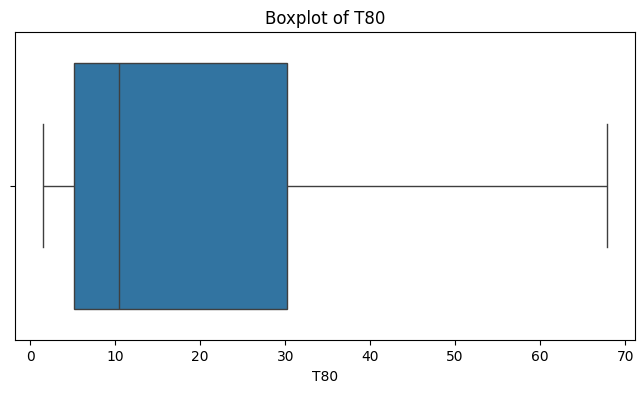

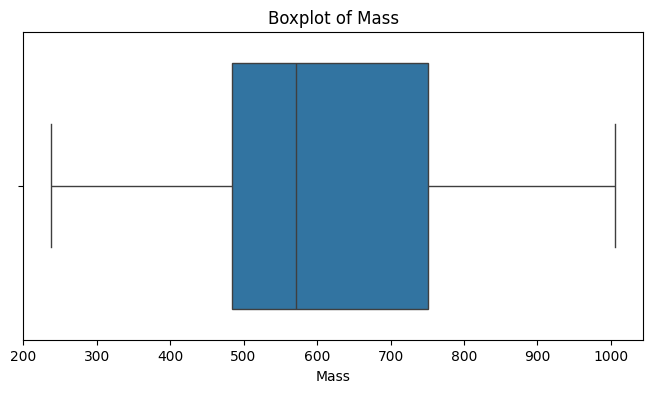

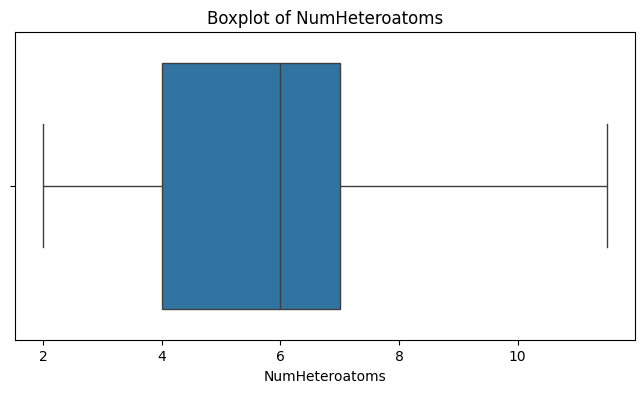

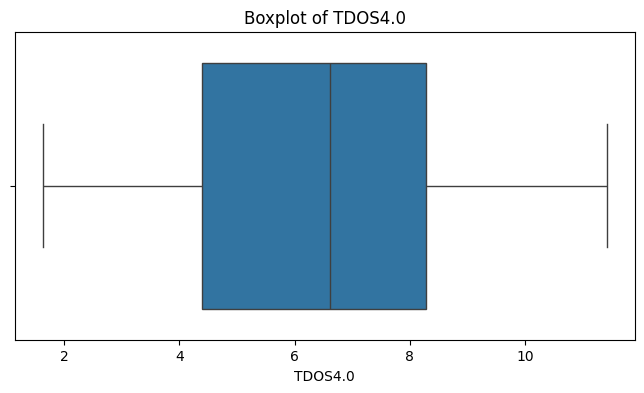

In [91]:
# Visualize outliers for key features
for feature in key_features:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df_train[feature])
    plt.title(f"Boxplot of {feature}")
    plt.show()

In [92]:
# Step 3: RDKit feature engineering
def compute_rdkit_features(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        return pd.Series({
            'MolWt': Descriptors.MolWt(mol),
            'MolLogP': Descriptors.MolLogP(mol),
            'NumValenceElectrons': Descriptors.NumValenceElectrons(mol),
            'TPSA': Descriptors.TPSA(mol)
        })
    except:
        return None

In [93]:
df_train_rdkit = df_train['Smiles'].apply(compute_rdkit_features)
df_test_rdkit = df_test['Smiles'].apply(compute_rdkit_features)
df_train = df_train.loc[~df_train_rdkit.isna().any(axis=1)]
df_test = df_test.loc[~df_test_rdkit.isna().any(axis=1)]
df_train = pd.concat([df_train, df_train_rdkit], axis=1)
df_test = pd.concat([df_test, df_test_rdkit], axis=1)

In [94]:
# Check for invalid SMILES
invalid_train = df_train_rdkit[df_train_rdkit.isna().any(axis=1)]
if not invalid_train.empty:
    print(f"Invalid SMILES in train: {df_train.loc[invalid_train.index, 'Batch_ID'].tolist()}")
    df_train = df_train.loc[~df_train_rdkit.isna().any(axis=1)]
    df_train_rdkit = df_train_rdkit.loc[~df_train_rdkit.isna().any(axis=1)]

invalid_test = df_test_rdkit[df_test_rdkit.isna().any(axis=1)]
if not invalid_test.empty:
    print(f"Invalid SMILES in test: {df_test.loc[invalid_test.index, 'Batch_ID'].tolist()}")
    df_test = df_test.loc[~df_test_rdkit.isna().any(axis=1)]
    df_test_rdkit = df_test_rdkit.loc[~df_test_rdkit.isna().any(axis=1)]

In [95]:
# Merge RDKit features
df_train = pd.concat([df_train, df_train_rdkit], axis=1)
df_test = pd.concat([df_test, df_test_rdkit], axis=1)

In [96]:
# Step 4: Feature selection
# Remove highly correlated features
numerical_columns = df_train.select_dtypes(include=[np.number]).columns.drop('T80')
corr_matrix = df_train[numerical_columns].corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
df_train = df_train.drop(columns=to_drop, errors='ignore')
df_test = df_test.drop(columns=to_drop, errors='ignore')

In [97]:
# Ensure key features are retained
key_features = ['TDOS4.0', 'NumHeteroatoms', 'Mass']
numerical_columns = [col for col in df_train.select_dtypes(include=[np.number]).columns if col != 'T80' and col in df_train.columns]

In [98]:
# Feature importance with Random Forest
X_train = df_train[numerical_columns]
y_train = df_train['T80']
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
feature_importance = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print("Top 10 features by importance:", feature_importance.head(10))

Top 10 features by importance: Mass                   0.345610
LUMOp1(eV)             0.096970
DipoleMoment(Debye)    0.053691
O6                     0.052919
HOMOm1(eV)             0.044930
O11                    0.043691
O3                     0.036702
O12                    0.026592
O7                     0.023661
O9                     0.023244
dtype: float64


In [99]:
# RFE with SVR
svr = SVR(kernel='linear')
rfe = RFE(estimator=svr, n_features_to_select=10)
rfe.fit(X_train, y_train)
selected_features = X_train.columns[rfe.support_].tolist()
print("Selected features by RFE:", selected_features)

Selected features by RFE: ['HAcceptors', 'HOMOm1(eV)', 'PrimeState', 'PrimeExcite(eV)', 'PrimeExcite(osc)', 'T2', 'O7', 'O8', 'O10', 'O14']


In [100]:
# Ensure key features are included
selected_features = list(set(selected_features + key_features).intersection(X_train.columns))
X_train = df_train[selected_features]
X_test = df_test[selected_features]

In [101]:
# Step 5: Data scaling
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [102]:
# Step 6: Model selection and tuning
models = {
    'SVR': SVR(),
    'RandomForest': RandomForestRegressor(random_state=42, n_jobs=-1),
    'XGBoost': XGBRegressor(random_state=42, n_jobs=-1),
    'LASSO': Lasso(random_state=42)
}
# Evaluate models with cross-validation
print("\nModel performance (RMSE):")
for name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse = np.sqrt(-scores.mean())
    print(f"{name}: {rmse:.4f} ± {np.sqrt(scores.std()):.4f}")


Model performance (RMSE):
SVR: 23.8078 ± 31.1588
RandomForest: 25.9535 ± 27.3652
XGBoost: 29.1438 ± 27.1562
LASSO: 27.8439 ± 26.4919


In [29]:
# Hyperparameter tuning for SVR (best model from prior research)
param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 1],
    'kernel': ['linear', 'rbf']
}
grid_search = GridSearchCV(SVR(), param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)
print("\nBest SVR parameters:", grid_search.best_params_)
print("Best SVR RMSE:", np.sqrt(-grid_search.best_score_))


Best SVR parameters: {'C': 0.1, 'epsilon': 0.1, 'kernel': 'rbf'}
Best SVR RMSE: 23.886546497540053


In [103]:
# Step 7: Ensemble predictions
svr = SVR(**grid_search.best_params_).fit(X_train_scaled, y_train)
rf = RandomForestRegressor(random_state=42, n_jobs=-1).fit(X_train_scaled, y_train)
xgb = XGBRegressor(random_state=42, n_jobs=-1).fit(X_train_scaled, y_train)

y_pred_svr = svr.predict(X_test_scaled)
y_pred_rf = rf.predict(X_test_scaled)
y_pred_xgb = xgb.predict(X_test_scaled)

In [104]:
# Weighted ensemble
y_pred_ensemble = 0.5 * y_pred_svr + 0.3 * y_pred_rf + 0.2 * y_pred_xgb
y_pred_ensemble = np.clip(y_pred_ensemble, 0, None)

In [ ]:
# # Step 8: Generate submission
# submission = pd.DataFrame({'Batch_ID': df_test['Batch_ID'], 'T80': y_pred_ensemble})
# submission.to_csv('submission20.csv', index=False)
# print("\nSubmission preview:")
# print(submission.head(10))

In [ ]:
# save the model

